Mounted at /content/drive


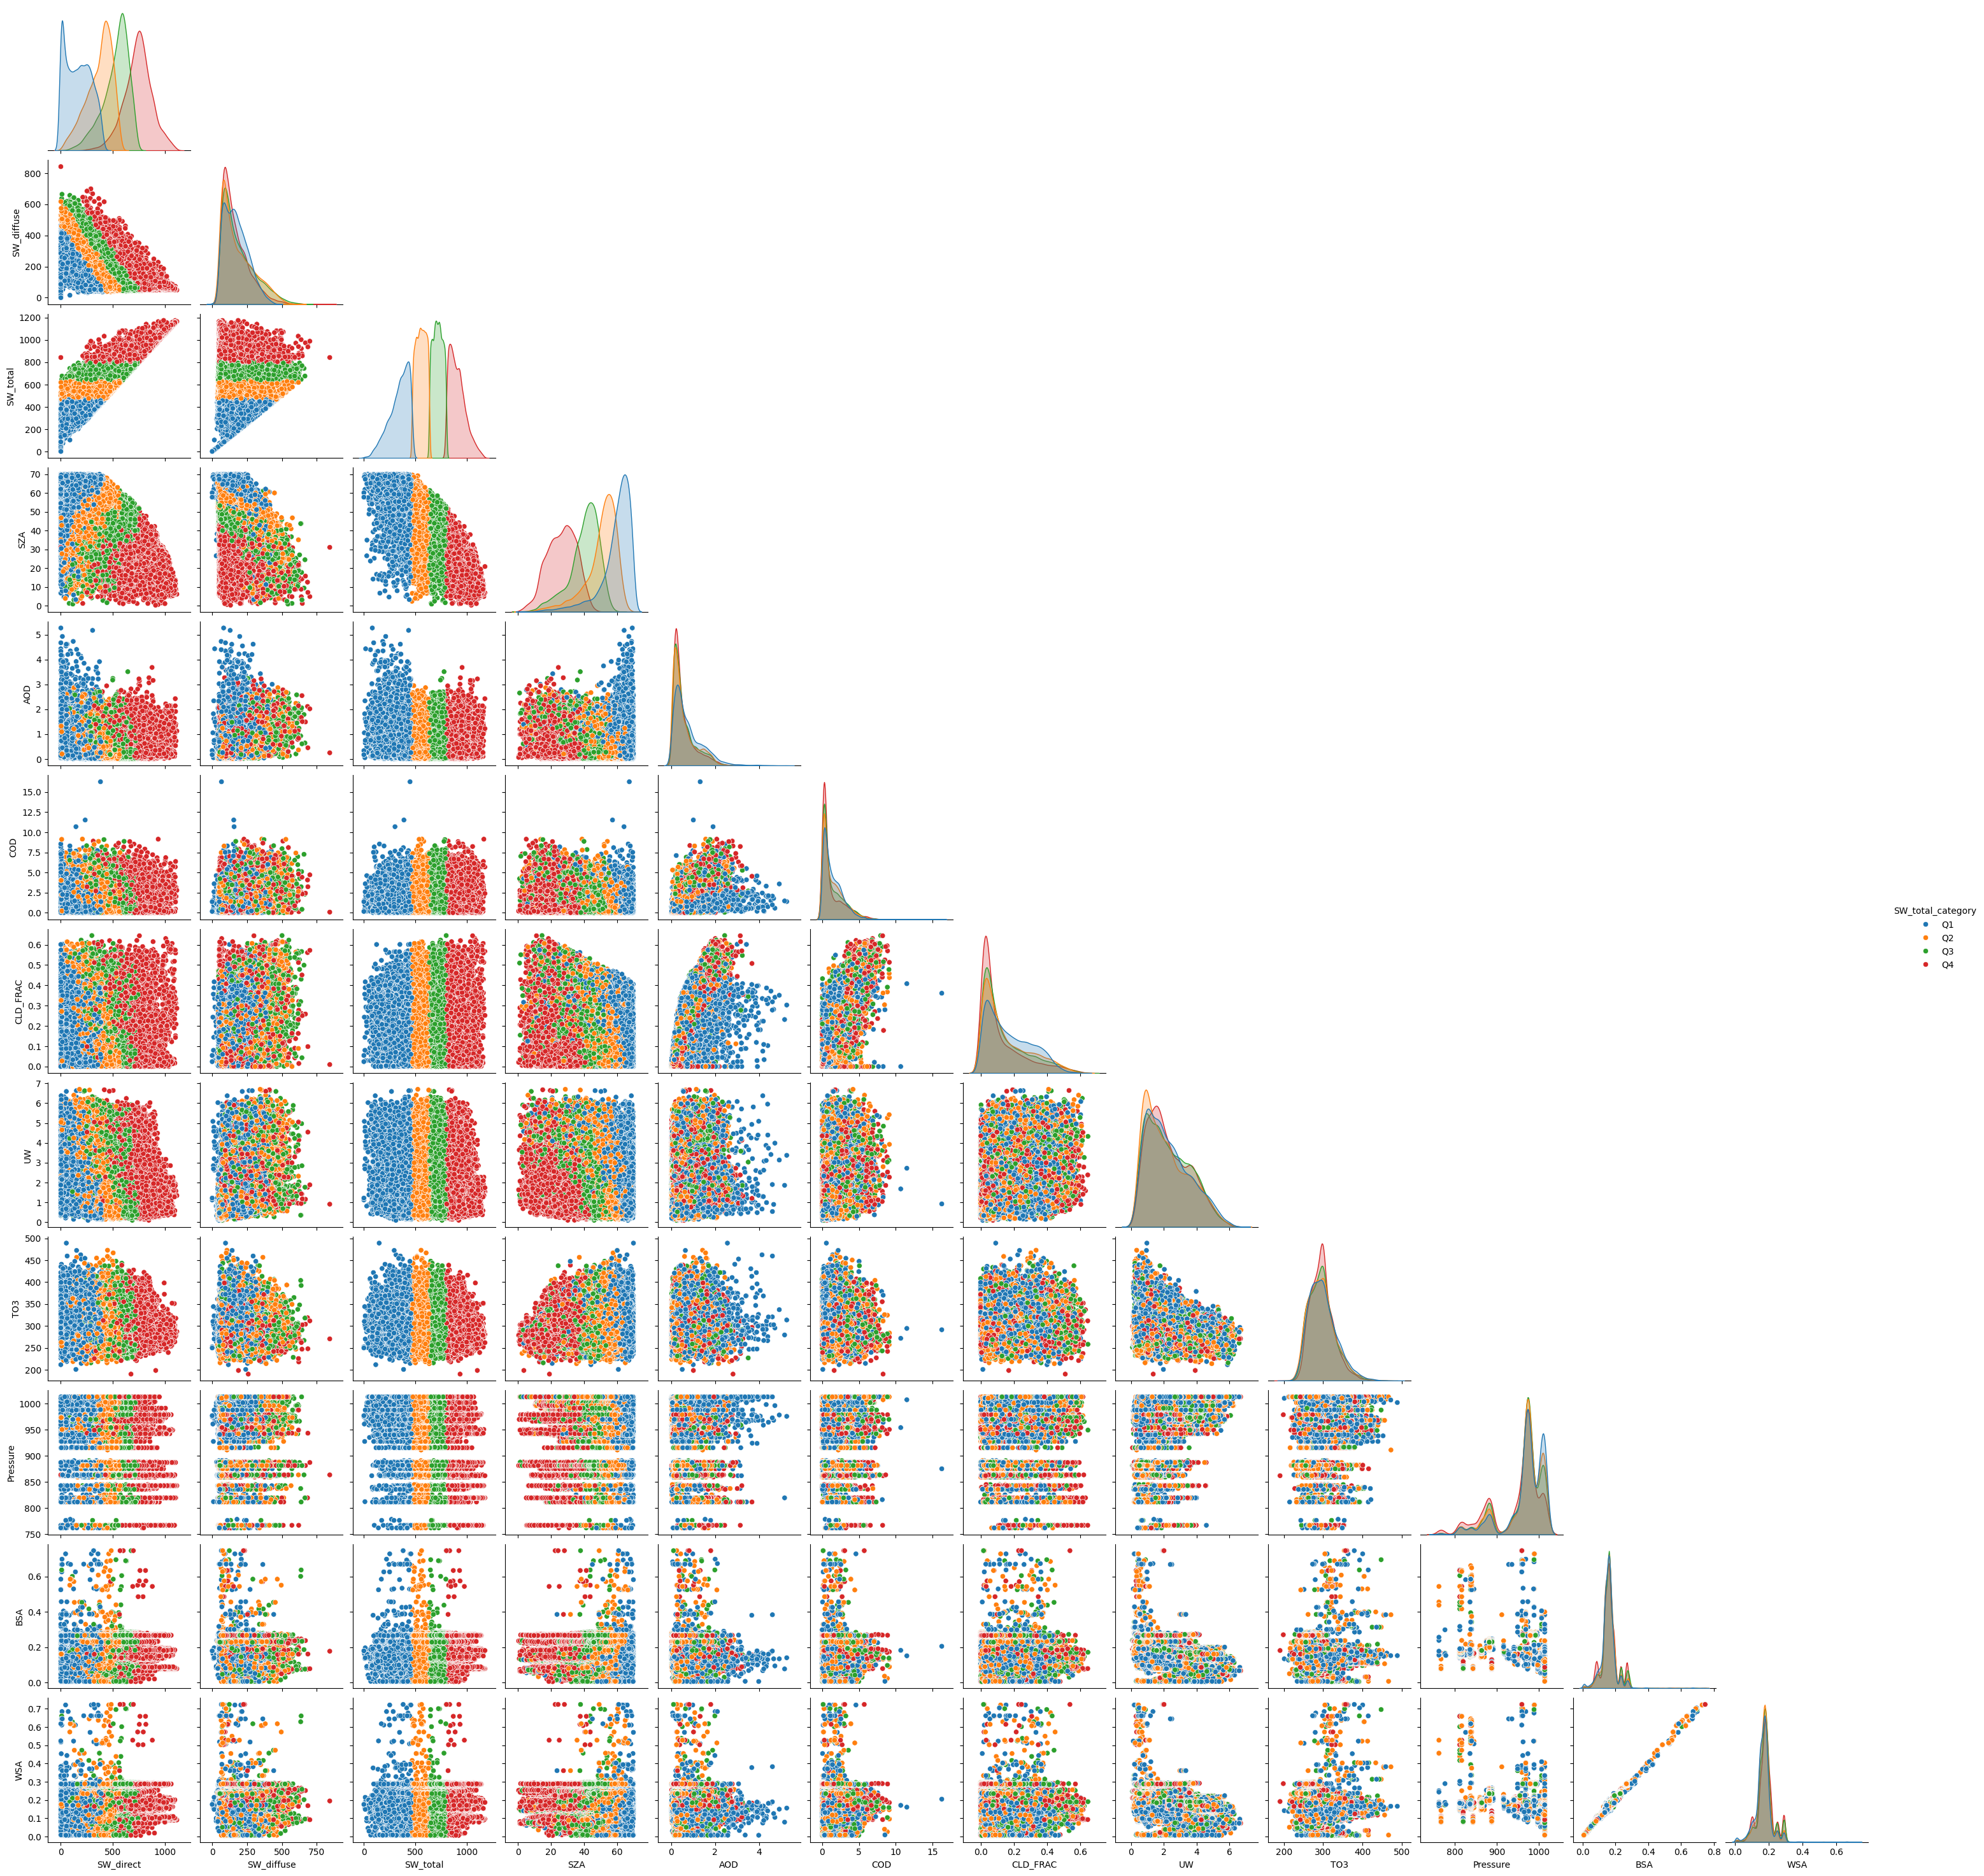

In [3]:
## Part 1: Data Preprocessing
import pandas as pd
import seaborn as sns

# Import file from google drive
from google.colab import drive
drive.mount('/content/drive')
filedir = '/content/drive/MyDrive/Colab_Notebooks/'
fname = filedir + "SW_with_AOD.csv"

# Read in file
BSRN = pd.read_csv(fname)

#Check for missing values
#BSRN.isna().sum() found none

# Create new column
BSRN["SW_total"] = BSRN["SW_direct"] + BSRN["SW_diffuse"]

# Create new categorical column
BSRN["SW_total_category"] = pd.qcut(BSRN["SW_total"], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Visual Exploration
sns.pairplot(BSRN, vars=["SW_direct", "SW_diffuse", "SW_total", "SZA", "AOD", "COD", "CLD_FRAC", "UW", "TO3", "Pressure", "BSA", "WSA"], hue="SW_total_category", corner=True)



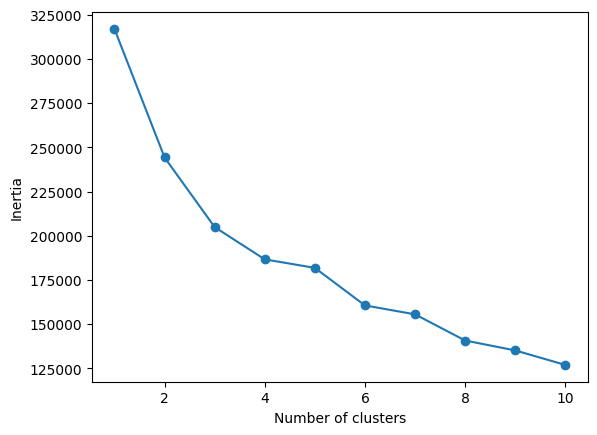

Cross-tabulation of Clusters vs. Class:
SW_total_category    Q1    Q2    Q3    Q4
row_0                                    
0                  4862  5055  4761  4388
1                  2662  2156  2128  1935
2                  1282  1595  1917  2483
The clusters do not align well with the solar radiation categories. Cluster 0 and 1 have an even spread of data points from all quartiles. 
 Cluster 3 has more from quartile 4.


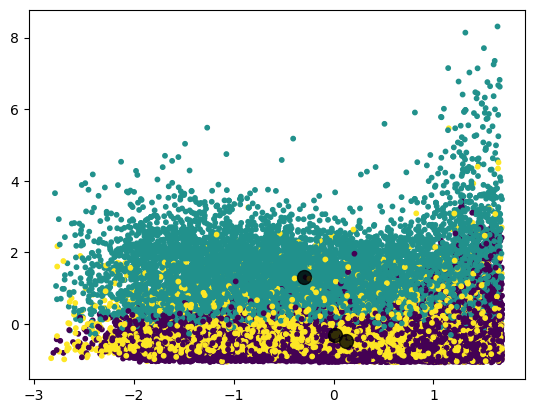

In [29]:
## Part 2: Unsupervised Learning

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# Normalize input features
scaler = StandardScaler()
X = BSRN[["SZA", "AOD", "COD", "CLD_FRAC", "UW", "TO3", "Pressure", "BSA", "WSA"]] #create variable with inputz
y = BSRN[["SW_total"]] #create variable with target
Xnew = scaler.fit_transform(X) #scale input variables

# K-Means clustering
inertias = []

for i in range(1,11): #iterate through different number of clusters
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(Xnew) #peform k-means on input variables for each number of clusters
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# From above elbow graph: optimal number of clusters is 3
kmeans = KMeans(n_clusters=3) #perform K-means using 3 clusters
kmeans.fit(Xnew)
y_kmeans = kmeans.predict(Xnew)


# Visualize the clusters with SZA and AOD
plt.scatter(Xnew[:,0],Xnew[:,1], c=y_kmeans, s=10)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.8);

# Do clusters align with SW_total_category?
cross_tab = pd.crosstab(y_kmeans, BSRN["SW_total_category"])
print("Cross-tabulation of Clusters vs. Class:")
print(cross_tab)

# Interpretation
print("The clusters do not align well with the solar radiation categories. Cluster 0 and 1 have an even spread of data points from all quartiles. \n Cluster 3 has more from quartile 4.")



Decision Tree RMSE: 11.88, R²: 0.591
Random Forest RMSE: 10.00, R²: 0.795
Most important feature is SZA
Accuracy KNeighborsClassifier: 0.6499810749432249 vs Accuracy GaussianNB: 0.6515897047691143
Precision KNeighborsClassifier: 0.648959365903789 vs Precision GaussianNB: 0.6552919104119476
Recall KNeighborsClassifier: 0.6499810749432249 vs Recall GaussianNB: 0.6515897047691143
The Gaussian Classification model performs better as it has greater accuracy, precision, and recall than the Kneighbors Classification Model


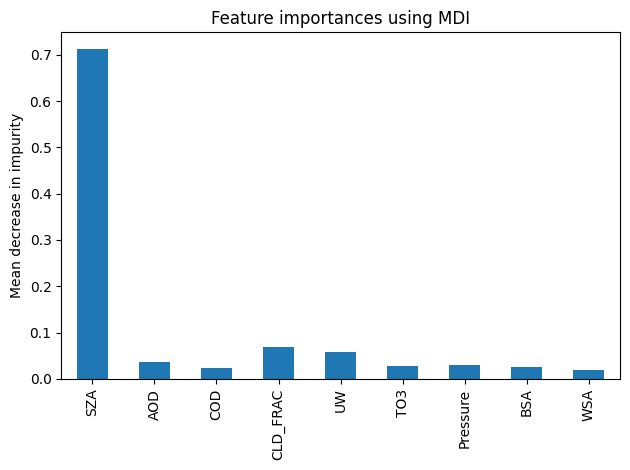

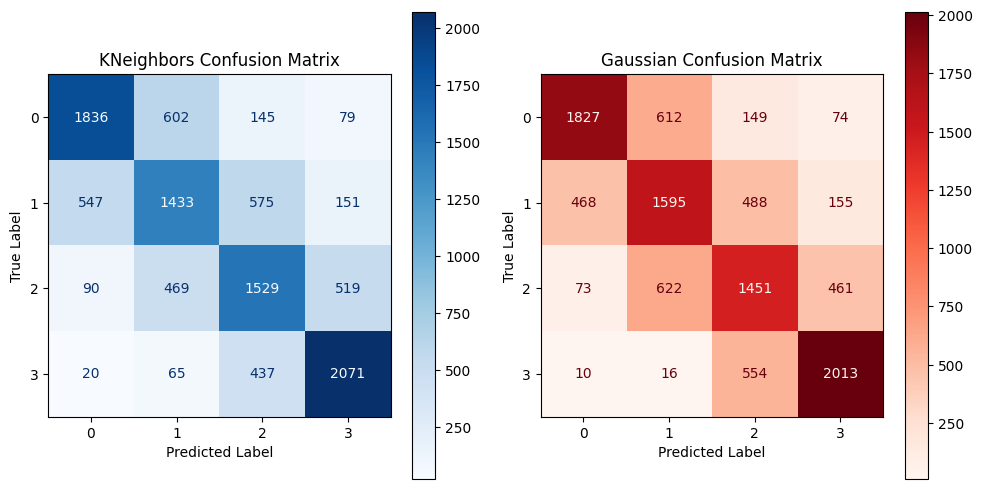

In [24]:
# Part 3: Supervised Learning

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import r2_score
from sklearn import metrics
import numpy as np

# Regression
X = BSRN[["SZA", "AOD", "COD", "CLD_FRAC", "UW", "TO3", "Pressure", "BSA", "WSA"]] #create variable with inputz
y = BSRN[["SW_total"]] #create variable with regression target
y = np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #Split dataset into training set and test set

# DecisionTreeRegressor
treemodel = DecisionTreeRegressor() #Create Decision Tree Regressor object
treemodel = treemodel.fit(X_train,y_train) #Train Decision Tree Regressor
y_pred_tree = treemodel.predict(X_test) #Predict the response for test dataset
rmse_tree = np.sqrt(root_mean_squared_error(y_test, y_pred_tree)) #calculate RMSE
r2_tree = r2_score(y_test, y_pred_tree) # Calculate R2

# RandomForestRegressor
forest = RandomForestRegressor(n_estimators=100, random_state=42) #Create Random Forest Regressor object
forest.fit(X_train, y_train) #Train Random Forest
y_pred_forest = forest.predict(X_test) #Predict the response for test dataset
rmse_forest = np.sqrt(root_mean_squared_error(y_test, y_pred_forest)) #calculate RMSE
r2_forest = r2_score(y_test, y_pred_forest) # Calculate R2

# Report Metrics
print(f"Decision Tree RMSE: {rmse_tree:.2f}, R²: {r2_tree:.3f}")
print(f"Random Forest RMSE: {rmse_forest:.2f}, R²: {r2_forest:.3f}")

# Feature Importance
importances = forest.feature_importances_ #find most import features from random forest model
feature_names = ["SZA", "AOD", "COD", "CLD_FRAC", "UW", "TO3", "Pressure", "BSA", "WSA"]
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots() #plot graph of feature importances
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
print("Most important feature is SZA")

# Classification
X = BSRN[["SZA", "AOD", "COD", "CLD_FRAC", "UW", "TO3", "Pressure", "BSA", "WSA"]] #create variable with inputs
y = BSRN[["SW_total_category"]] #create variable with classification target
y = np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #Split dataset into training set and test set

# KNeighborsClassifier

knn = KNeighborsClassifier ()
knn = knn.fit (X_train, y_train)
y_pred_KN = knn.predict(X_test)

# GaussianNB
gnb = GaussianNB()
gnb = gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

# Report metrics
print("Accuracy KNeighborsClassifier:",metrics.accuracy_score(y_test, y_pred_KN), "vs Accuracy GaussianNB:", metrics.accuracy_score(y_test, y_pred_gnb))
print("Precision KNeighborsClassifier:",metrics.precision_score(y_test, y_pred_KN, average="weighted"), "vs Precision GaussianNB:", metrics.precision_score(y_test, y_pred_gnb, average="weighted"))
print("Recall KNeighborsClassifier:",metrics.recall_score(y_test, y_pred_KN, average="weighted"), "vs Recall GaussianNB:", metrics.recall_score(y_test, y_pred_gnb, average="weighted"))
print("The Gaussian Classification model performs better as it has greater accuracy, precision, and recall than the Kneighbors Classification Model")


#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_KN)
cm2 = confusion_matrix(y_test, y_pred_gnb)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

cmkn = ConfusionMatrixDisplay(cm)
cmkn.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('KNeighbors Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

cmgnb = ConfusionMatrixDisplay(cm2)
cmgnb.plot(ax=axes[1], cmap=plt.cm.Reds)
axes[1].set_title('Gaussian Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()


Part 4

SZA (Solar Zenith Angle) is the most important feature for predicting total shortwave radiation. The second most important feature is Cloud Fraction, however it has far less influence than SZA.

The K-means clustering seemed unable to group data aligned with the SW_total_category quartiles. It appears that a regression model works better than a classification model.

Thus, I would recommend the random forest regression model for solar radiation prediction as it performed better than the decision tree, having a R2 score of 0.8 compared to 0.6. Additionally it had a smaller RMSE.